The question to explore is the following: given Kepler observations, how many events of the following type are we likely to observe as single eclipse events?

* EBs
* BEBs
* HEBs

More specifically, given a period and depth range, how many of each do I predict? 

In [6]:
from keputils import kicutils as kicu
stars = kicu.DATA # This is Q17 stellar table.

OK, first, let's calculate the number of expected EBs.  That is, assign each Kepler target star a binary companion according to the Raghavan (2010) distribution, and see what the eclipsing population looks like. Let's use tools from `vespa` to make this happen.

In [8]:
stars = stars.query('mass > 0') #require there to be a mass.
len(stars)

196469

In [9]:
from vespa.stars import Raghavan_BinaryPopulation

binpop = Raghavan_BinaryPopulation(M=stars.mass)

In [18]:
binpop.stars.columns

Index([u'H_mag', u'H_mag_A', u'J_mag', u'J_mag_A', u'K_mag', u'K_mag_A',
       u'Kepler_mag', u'Kepler_mag_A', u'Teff_A', u'age_A', u'g_mag',
       u'g_mag_A', u'i_mag', u'i_mag_A', u'logL_A', u'logg_A', u'mass_A',
       u'r_mag', u'r_mag_A', u'radius_A', u'z_mag', u'z_mag_A', u'H_mag_B',
       u'J_mag_B', u'K_mag_B', u'Kepler_mag_B', u'Teff_B', u'age_B',
       u'g_mag_B', u'i_mag_B', u'logL_B', u'logg_B', u'mass_B', u'r_mag_B',
       u'radius_B', u'z_mag_B', u'q', u'distance', u'distmod'],
      dtype='object')

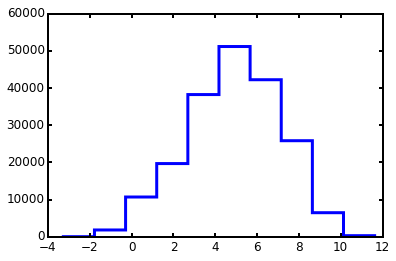

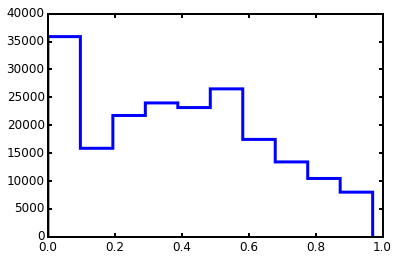

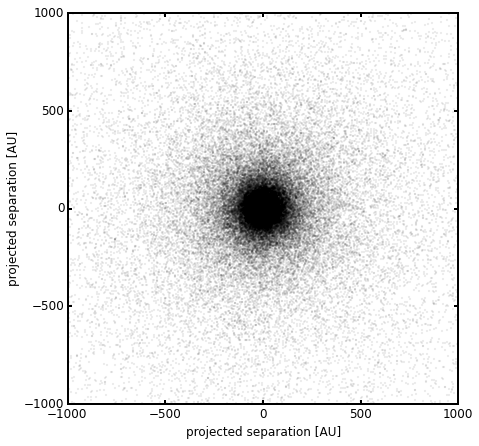

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# e.g., 
plt.hist(np.log10(binpop.orbpop.P.value), histtype='step', lw=3);
plt.figure()
plt.hist(binpop.orbpop.ecc, histtype='step', lw=3);
plt.figure()
binpop.orbpop.scatterplot(ms=0.05, rmax=1000);

In [51]:
# Determine eclipse probabilities

import astropy.units as u

ecl_prob = ((binpop.stars.radius_A.values + binpop.stars.radius_B.values)*u.Rsun / binpop.orbpop.semimajor).decompose()

In [52]:
sum(ecl_prob > 1) # These will need to be ignored later. 
ok = ecl_prob < 1

In [54]:
# Rough estimate of numbers of systems with eclipsing orientation
ecl_prob[ok].sum()

<Quantity 4078.1133987553258>

In [65]:
# OK, how many that have periods less than 1 years?
kep_ok = (ok & (binpop.orbpop.P < 3*u.yr))
ecl_prob[kep_ok].sum()

<Quantity 3553.6061387495756>

In [59]:
# And, including binary fraction
fB = 0.4
fB * ecl_prob[kep_ok].sum()

<Quantity 1421.4424554998304>

This is actually a bit low compared to the Kepler EB catalog haul of 2878 EBs.  However, keep in mind that this is only looking at *binaries*, not considering triple systems that tend to have much closer pairs.  So to my eye this is actually a pretty believable number.  (Also note that this does not take eccentricity into account.)  How many of these would have periods from 5 to 15 years?

In [72]:
minP = 5*u.yr; maxP = 15*u.yr
kep_long = ok & (binpop.orbpop.P > minP) & (binpop.orbpop.P < maxP)
fB * ecl_prob[kep_long].sum()

<Quantity 72.70249443502489>

This seems like a lot.  Now keep in mind this is just the number with eclipsing *geometry*, not the number that would actually show up within the Kepler data, taking the window function into account.  A quick hack at this would be that the probability for an eclipse to be within the Kepler window would be `4yr / P`.

In [73]:
in_window = np.clip(4*u.yr / binpop.orbpop.P, 0, 1).decompose()

fB*(ecl_prob[kep_long] * in_window[kep_long]).sum()

<Quantity 36.633186365026056>

OK, better, but this still seems like a lot.  Perhaps I'm doing something wrong here?  Accounting properly for eccentricity in the transit probability will only make this number larger.  Of course, only a fraction of these would be plausibly planetary-like signals, but still, this seems like an overestimate, though not crazy.